# Interpolation Testbed Notebook

Short notebook to test various interpolation strategies. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import RandomForestRegressor

#### Setting up fake data

In [2]:
num_of_sensors = 12
num_of_leaks = 11

The dimmensions for this test case is a square, just a demo

In [3]:
dim_lim_low = 24
dim_lim_high = 112

## Create x and y locations

This code is just needed for the test, in the real analysis, this will use C Becker's data sampling scheme

In [4]:
x_sensors = np.random.randint(dim_lim_low, dim_lim_high, size=num_of_sensors)
y_sensors = np.random.randint(dim_lim_low, dim_lim_high, size=num_of_sensors)

Let's make a fake z

In [5]:
random_values = np.random.uniform(-0.5, 0.5, num_of_sensors)
z_sensors = 2*np.sin(np.sqrt(x_sensors**2 + y_sensors**2)) + 0.5*np.cos(np.sqrt(x_sensors**2 + y_sensors**2)+2) + 5 + random_values*0.25

Text(0.5, 1.0, 'Fake sensor measurements')

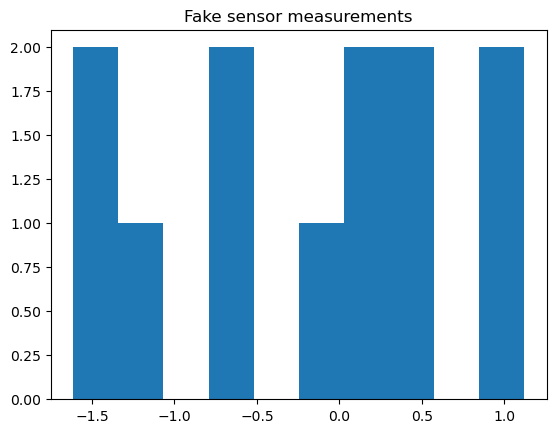

In [6]:
z_sensors = z_sensors - np.median(z_sensors)
plt.hist(z_sensors)
plt.title('Fake sensor measurements')

In [7]:
cut_in = 4 # just a parameter to get the leaks towards the middle of the plane

x_leaks = np.random.randint(dim_lim_low+cut_in, dim_lim_high-cut_in, size=num_of_leaks)
y_leaks = np.random.randint(dim_lim_low+cut_in, dim_lim_high-cut_in, size=num_of_leaks)

#### Quick Plot

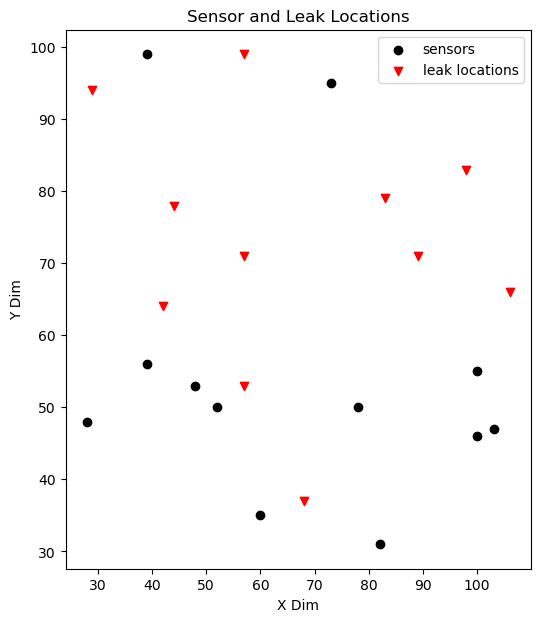

In [8]:
plt.figure(figsize=(6, 7))

plt.scatter(x_sensors, y_sensors, label='sensors', color='black')
plt.scatter(x_leaks, y_leaks, marker="v", label='leak locations', color='red')

plt.legend()
plt.xlabel('X Dim')
plt.ylabel('Y Dim')
plt.title('Sensor and Leak Locations')

plt.show()

This is just for this toy problem, won't be used for the actual code as it will come from the data loader as built by C Becker.

## Interpolate the Data

In [9]:
def create_meshgrid(x_sensors, y_sensors, buffer=6, grid_points=100):
    """
    Create a meshgrid based on sensor positions.

    Parameters:
    - x_sensors (array-like): x-coordinates of sensor positions.
    - y_sensors (array-like): y-coordinates of sensor positions.
    - buffer (float, optional): Buffer value added to the minimum and maximum coordinates for each axis.
    - grid_points (int, optional): Number of grid points in each dimension.

    Returns:
    - x_new (ndarray): Meshgrid for x-coordinates.
    - y_new (ndarray): Meshgrid for y-coordinates.
    """
    x_new, y_new = np.mgrid[min(x_sensors)-buffer:max(x_sensors)+buffer:grid_points*1j, min(y_sensors)-buffer:max(y_sensors)+buffer:grid_points*1j]
    return x_new, y_new

In [10]:
x_new, y_new = create_meshgrid(x_sensors, y_sensors, buffer=6, grid_points=100)

#### Using SciPy griddata

In [11]:
%%time

# Performing 2D interpolation
z_interpolated = griddata((x_sensors, y_sensors), z_sensors, (x_new, y_new), method='cubic')

# Finding Global Max and it's indicies
max_z = np.nanmax(z_interpolated)
max_indices = np.where(max_z == z_interpolated)

CPU times: user 4.92 ms, sys: 1.19 ms, total: 6.11 ms
Wall time: 1.87 ms


#### Using Scikit-learn methods

This uses the scikit-learn API:# Make training data
X_train = np.column_stack((x_sensors, y_sensors))
y_train = z_sensors

In [12]:
# Make training data
X_train = np.column_stack((x_sensors, y_sensors))
y_train = z_sensors

#### Gaussian Processes Regressor

In [13]:
%%time

# Define the kernel for Gaussian Process (RBF kernel is used here)
kernel = RBF() # length scale could be adjusted

# Create the Gaussian Process Regressor
gp_model = GaussianProcessRegressor(kernel=kernel)

# Fit the model with the data
gp_model.fit(X_train, y_train)

# Make some test data
X_test = np.column_stack((x_new.ravel(), y_new.ravel()))

# Predict interpolated values
interpolated_values_gp, std = gp_model.predict(X_test, return_std=True)
reshaped_gp_results = interpolated_values_gp.reshape(100,100)

# Finding Global Max and it's indicies using the gaussian process model
max_z_gp = np.nanmax(reshaped_gp_results)
max_indices_gp = np.where(max_z_gp == reshaped_gp_results)

CPU times: user 43 ms, sys: 4.19 ms, total: 47.2 ms
Wall time: 10.2 ms


#### Random Forest Model

Maybe can add wind (U, V, W, etc.) to this model? This should be slow, but might be better for rough / less smooth data sets. 

In [14]:
%%time
# Create the Random Forest Regressor with max depth set to 2
rf_model = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=42)

# Fit the model with the data
rf_model.fit(X_train, y_train)

# Make some test data
X_test = np.column_stack((x_new.ravel(), y_new.ravel()))

# Predict interpolated values
interpolated_values_rf = rf_model.predict(X_test)
reshaped_rf_results = interpolated_values_rf.reshape(100, 100)

# Finding Global Max and its indices using the Random Forest model
max_z_rf = np.nanmax(reshaped_rf_results)
max_indices_rf = np.unravel_index(np.argmax(reshaped_rf_results), reshaped_rf_results.shape)

CPU times: user 109 ms, sys: 169 ms, total: 278 ms
Wall time: 35.1 ms


## Find which sensor has the highest value

In [15]:
def find_closest_value(arr1, arr2):
    closest_values = []

    for val1 in arr1:
        closest_val = min(arr2, key=lambda x: abs(x - val1))
        closest_values.append(closest_val)

    return closest_values

In [16]:
closest_values_x = find_closest_value(x_leaks, x_new[:,0])
closest_values_x

[29.03030303030303,
 57.15151515151515,
 57.15151515151515,
 82.63636363636363,
 106.36363636363636,
 67.69696969696969,
 42.21212121212121,
 57.15151515151515,
 97.57575757575758,
 88.78787878787878,
 43.96969696969697]

In [17]:
closest_values_y = find_closest_value(y_leaks, y_new[0,:])
closest_values_y

[93.68686868686869,
 71.06060606060606,
 53.282828282828284,
 79.14141414141415,
 66.21212121212122,
 37.121212121212125,
 63.78787878787879,
 99.34343434343434,
 83.18181818181819,
 71.06060606060606,
 78.33333333333334]

In [18]:
def find_indices(arr, values_to_find):
    indices = np.concatenate([np.where(arr == val)[0] for val in values_to_find])
    return indices

In [19]:
indices_x = find_indices(x_new[:,0], closest_values_x)
indices_x

array([ 8, 40, 40, 69, 96, 52, 23, 40, 86, 76, 25])

In [20]:
indices_y = find_indices(y_new[0,:], closest_values_y)
indices_y

array([85, 57, 35, 67, 51, 15, 48, 92, 72, 57, 66])

In [21]:
print("Which Leak location is most likely? - Using Standard Interpolator")
index_of_max_value = np.nanargmax(z_interpolated[indices_x, indices_y])
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value)

Which Leak location is most likely? - Using Standard Interpolator
Index of the maximum value (ignoring NaN) is: 1


In [22]:
print("Which Leak location is most likely - Using Gaussian processes?")
index_of_max_value_gp = np.nanargmax(reshaped_gp_results[indices_x, indices_y])
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value_gp)

Which Leak location is most likely - Using Gaussian processes?
Index of the maximum value (ignoring NaN) is: 5


In [23]:
print("Which Leak location is most likely - Using Random Forest?")
index_of_max_value_rf = np.nanargmax(reshaped_rf_results[indices_x, indices_y])
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value_rf)

Which Leak location is most likely - Using Random Forest?
Index of the maximum value (ignoring NaN) is: 2


## Comparison Plot

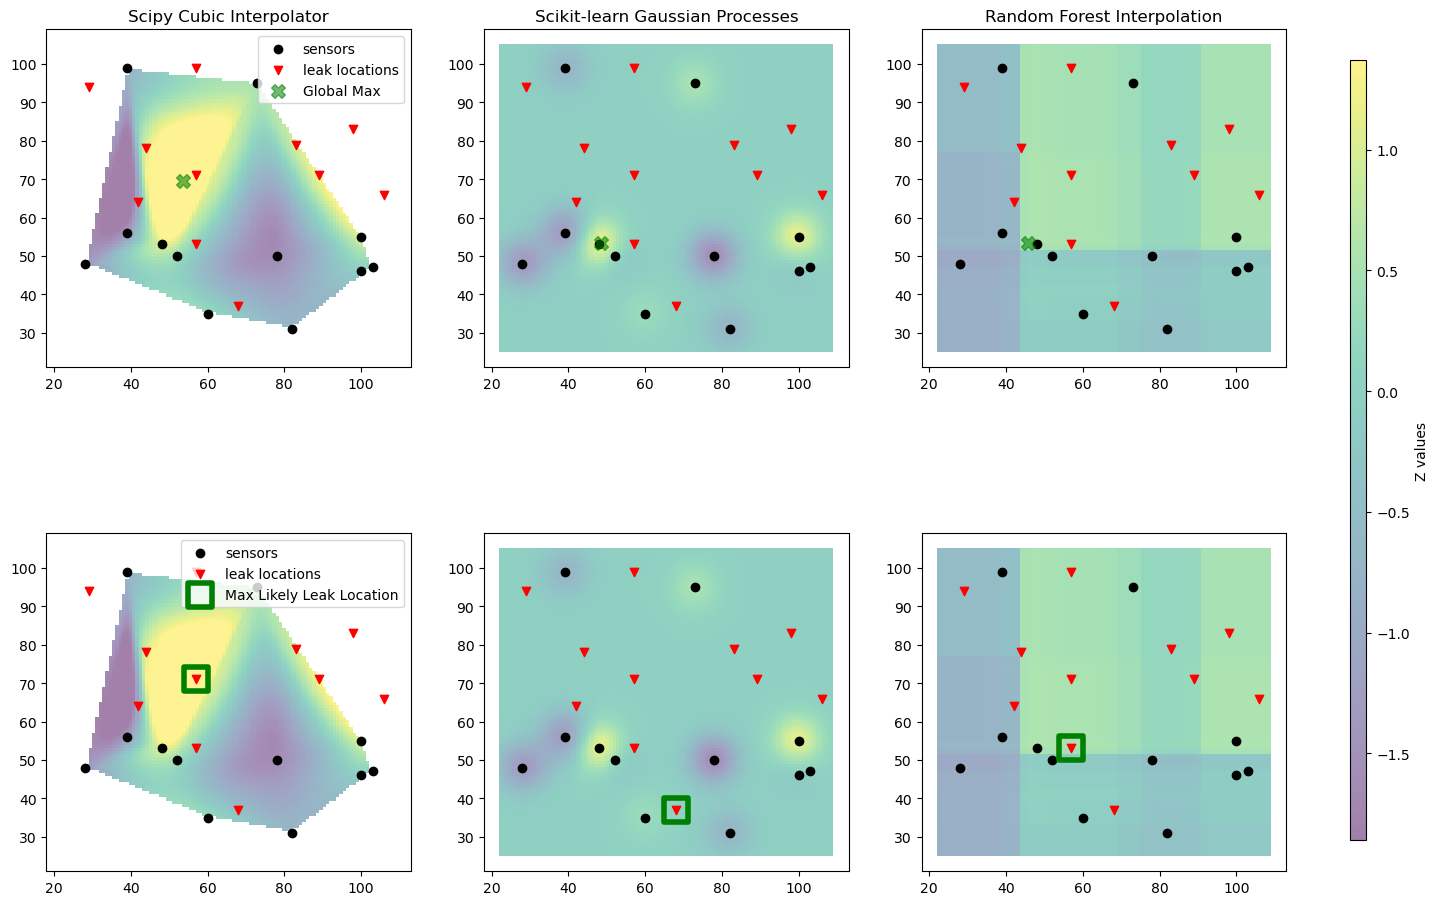

In [24]:
# Calculate the overall minimum and maximum values for the color bar range
buffer = 6

global_min = np.round(np.min(z_sensors),2)-0.25
global_max = np.round(np.max(z_sensors),2)+0.25

fig, axes = plt.subplots(2, 3, figsize=(16, 12))

# Common settings for all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.scatter(x_sensors, y_sensors, label='sensors', color='black')
        ax.scatter(x_leaks, y_leaks, marker="v", label='leak locations', color='red')
        ax.set_xlim(min(x_sensors-buffer-4), max(x_sensors+buffer+4))
        ax.set_ylim(min(y_sensors-buffer-4), max(y_sensors+buffer+4))
        # ax.set_clim(global_min, global_max)  # Set color bar range

        
# Plot 1 - First Block
img = axes[0,0].imshow(z_interpolated.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img.set_clim(global_min, global_max)  # Set color bar range

axes[0, 0].scatter(x_new[max_indices[0][0]][0], y_new[0][max_indices[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[0, 0].legend()
axes[0, 0].set_title('Scipy Cubic Interpolator')

# Plot 2 - Second Block

img2 = axes[0,1].imshow(reshaped_gp_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img2.set_clim(global_min, global_max) 

axes[0, 1].scatter(x_new[max_indices_gp[0][0]][0], y_new[0][max_indices_gp[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[0, 1].set_title('Scikit-learn Gaussian Processes')

# Plot 4 - Third Block
img4 = axes[1,0].imshow(z_interpolated.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img4.set_clim(global_min, global_max) 

axes[1, 0].scatter(x_leaks[index_of_max_value], y_leaks[index_of_max_value], marker="s", label='Max Likely Leak Location', color='Green', facecolors='none', s=300, linewidths=4)
axes[1, 0].legend()

# Plot 5 - Fourth Block
img5 = axes[1,1].imshow(reshaped_gp_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img5.set_clim(global_min, global_max) 
axes[1, 1].scatter(x_leaks[index_of_max_value_gp], y_leaks[index_of_max_value_gp], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)

# Third Across
img3 = axes[0,2].imshow(reshaped_rf_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img3.set_clim(global_min, global_max) 

axes[0, 2].scatter(x_new[max_indices_rf[0]][0], y_new[0][max_indices_rf[1]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[0, 2].set_title('Random Forest Interpolation')

# Third Across, second row
img6 = axes[1,2].imshow(reshaped_rf_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img6.set_clim(global_min, global_max) 

axes[1, 2].scatter(x_leaks[index_of_max_value_rf], y_leaks[index_of_max_value_rf], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)


# Add colorbar
cbar_ax = fig.add_axes([.94, 0.17, 0.01, 0.65])  # [x, y, width, height]
cbar = plt.colorbar(img, cax=cbar_ax)
cbar.set_label('Z values')

# plt.tight_layout()
plt.show()